In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
import imutils
import argparse
import os
import math


In [3]:
SIGNS = ["STOP",
        "TURN RIGHT",
        "TURN LEFT"]

In [4]:
ls

 labels.csv     model_trained.p   Output.txt                    test.png
 main.py        MVI_1049.avi      requirements.txt              test.py
'main signs'/   myData/          'Signs Classification.ipynb'   train.py
 model.h5       output.avi       'Signs Detection.ipynb'        venv/


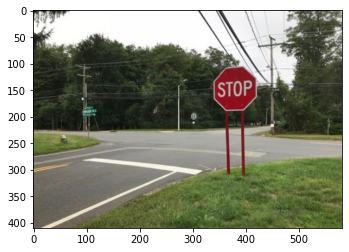

In [42]:
test_im = cv2.imread('test.png')
test_im = cv2.cvtColor(test_im, cv2.COLOR_BGR2RGB)
plt.imshow(test_im)

In [43]:
### Preprocess image
def constrastLimit(image):
    img_hist_equalized = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    channels = cv2.split(img_hist_equalized)
    channels[0] = cv2.equalizeHist(channels[0])
    img_hist_equalized = cv2.merge(channels)
    img_hist_equalized = cv2.cvtColor(img_hist_equalized, cv2.COLOR_YCrCb2BGR)
    return img_hist_equalized

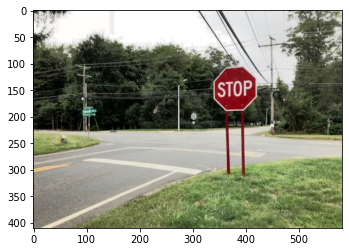

In [44]:
ctr_im = constrastLimit(test_im)
plt.imshow(ctr_im)

In [45]:
def LaplacianOfGaussian(image):
    LoG_image = cv2.GaussianBlur(image, (3,3), 0)           # paramter 
    gray = cv2.cvtColor( LoG_image, cv2.COLOR_BGR2GRAY)
    LoG_image = cv2.Laplacian( gray, cv2.CV_8U,3,3,2)       # parameter
    LoG_image = cv2.convertScaleAbs(LoG_image)
    return LoG_image
    

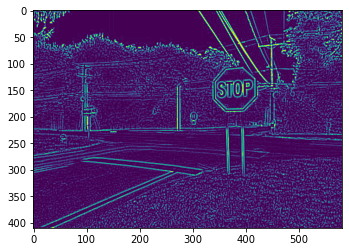

In [46]:
lap_im = LaplacianOfGaussian(test_im)
plt.imshow(lap_im)

In [47]:
def binarization(image):
    thresh = cv2.threshold(image,32,255,cv2.THRESH_BINARY)[1]
    #thresh = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    return thresh

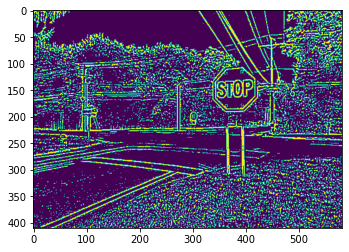

In [48]:
bin_im = binarization(lap_im)
plt.imshow(bin_im)

In [49]:
def preprocess_image(image):
    image = constrastLimit(image)
    image = LaplacianOfGaussian(image)
    image = binarization(image)
    return image
pre_im = preprocess_image(test_im)

In [50]:
def removeSmallComponents(image, threshold):
    #find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[1:, -1]; nb_components = nb_components - 1

    img2 = np.zeros((output.shape),dtype = np.uint8)
    #for every component in the image, you keep it only if it's above threshold
    for i in range(0, nb_components):
        if sizes[i] >= threshold:
            img2[output == i + 1] = 255
    return img2


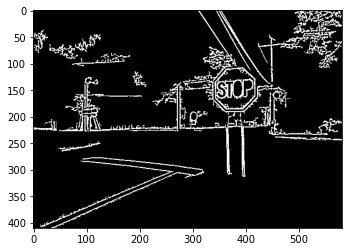

In [51]:
pre_im = removeSmallComponents(pre_im,200)
plt.imshow(pre_im,cmap='gray')

In [70]:
def largest_cont(edg):
    cnts, hierarchy  = cv2.findContours(edg.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #select contour with the biggest area
    cnt = max(cnts , key = cv2.contourArea)
    #perimeter approximation (True --> closed contour)
    return cnt

In [71]:
def draw_cont(img,edg):
    #draw contours
    cnts, hierarchy  = cv2.findContours(edg.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts , key = cv2.contourArea)
    return cv2.drawContours(img.copy(), [cnt], -1, (0,255,0), 3)

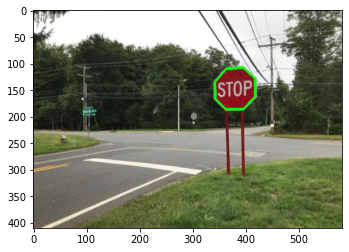

In [72]:
plt.imshow(draw_cont(test_im,pre_im))

In [73]:
def correct(cont,img):
    lig=cont.shape[0]
    cont=cont.reshape(lig,2)
    rect = np.zeros((4,2), dtype="float32")

    #quadrilateral estimation
    s = np.sum(cont, axis=1)
    rect[0] = cont[np.argmin(s)]
    rect[2] = cont[np.argmax(s)]

    diff = np.diff(cont, axis=1)
    rect[1] = cont[np.argmin(diff)]
    rect[3] = cont[np.argmax(diff)]

    (A, B, C, D) = rect

    #quadrilateral max(hauteur,largeur)
    widthA = np.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2 )
    widthB = np.sqrt((D[0] - C[0])**2 + (D[1] - C[1])**2 )
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt((A[0] - D[0])**2 + (A[1] - D[1])**2 )
    heightB = np.sqrt((B[0] - C[0])**2 + (B[1] - C[1])**2 )
    maxHeight = max(int(heightA), int(heightB))

    #reference quadrilateral
    dst = np.array([
    [0,0],
    [maxWidth-1, 0],
    [maxWidth-1, maxHeight-1],
    [0, maxHeight-1]], dtype="float32")

    #transformation matrix (original quad --> reference quad)
    BansformMaBix = cv2.getPerspectiveTransform(rect, dst)
    #affine transformation
    scan = cv2.warpPerspective(img.copy(), BansformMaBix, (maxWidth, maxHeight),borderMode=cv2.BORDER_REPLICATE)

    return scan

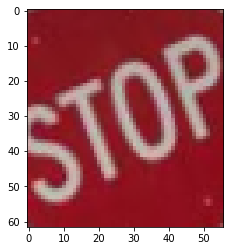

In [80]:
main_cont=largest_cont(pre_im)
plt.imshow(correct(main_cont,test_im))